In [6]:
import re
import networkx as nx
import matplotlib.pyplot as plt
import pydot
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pandas as pd
import subprocess

from copy import deepcopy

In [7]:
def parse_alb(alb_file_name):
    """Reads assembly line balancing instance .alb file, returns dictionary with the information"""
    parse_dict = {}
    alb_file = open(alb_file_name).read()
    # Get number of tasks
    num_tasks = re.search("<number of tasks>\n(\\d*)", alb_file)
    parse_dict["num_tasks"] = int(num_tasks.group(1))

    # Get cycle time
    cycle_time = re.search("<cycle time>\n(\\d*)", alb_file)
    parse_dict["cycle_time"] = int(cycle_time.group(1))

    # Order Strength
    order_strength = re.search("<order strength>\n(\\d*,\\d*)", alb_file)
    
    if order_strength:
        parse_dict["original_order_strength"] = float(order_strength.group(1).replace(",", "."))
    else:
        order_strength = re.search("<order strength>\n(\\d*.\\d*)", alb_file)
        parse_dict["original_order_strength"] = float(order_strength.group(1))

    # Task_times
    task_times = re.search("<task times>(.|\n)+?<", alb_file)

    # Get lines in this regex ignoring the first and last 2
    task_times = task_times.group(0).split("\n")[1:-2]
    task_times = {task.split()[0]: int(task.split()[1]) for task in task_times}
    parse_dict["task_times"] = task_times

    # Precedence relations
    precedence_relations = re.search("<precedence relations>(.|\n)+?<", alb_file)
    precedence_relations = precedence_relations.group(0).split("\n")[1:-2]
    precedence_relations = [task.split(",") for task in precedence_relations]
    parse_dict["precedence_relations"] = precedence_relations
    return parse_dict

def write_to_alb(salbp_dict, alb_file_name):
    """Writes the SALBP dictionary to an .alb file"""
    #Format of alb:
    # <number of tasks>
    # no_tasks
    # <cycle time>
    # cycle_time
    #<task times>
    #task_id task_time
    #<precedence relations>
    #task_id,task_id


    # Write number of tasks
    alb = "<number of tasks>\n"
    alb += str(salbp_dict["num_tasks"]) + "\n"
    # Write cycle time
    alb += "<cycle time>\n"
    alb += str(salbp_dict["cycle_time"]) + "\n"
    # Write task times
    alb += "<task times>\n"
    for task_id, task_time in salbp_dict["task_times"].items():
        alb += task_id + " " + str(task_time) + "\n"
    # Write precedence relations
    alb += "<precedence relations>\n"
    for relation in salbp_dict["precedence_relations"]:
        alb += relation[0] + "," + relation[1] + "\n"
    #ends the file
    alb += "<end>"
    with open(alb_file_name, "w") as alb_file:
        alb_file.write(alb)
    


SALBP_dict = parse_alb("small data set_n=20/instance_n=20_2.alb")
write_to_alb(SALBP_dict, "test.alb")

In [ ]:
SALBP_dict

{'num_tasks': 20,
 'cycle_time': 1000,
 'original_order_strength': 0.3,
 'task_times': {'1': 58,
  '2': 224,
  '3': 20,
  '4': 150,
  '5': 410,
  '6': 117,
  '7': 262,
  '8': 94,
  '9': 213,
  '10': 118,
  '11': 191,
  '12': 74,
  '13': 60,
  '14': 117,
  '15': 124,
  '16': 103,
  '17': 178,
  '18': 188,
  '19': 107,
  '20': 53},
 'precedence_relations': [['1', '13'],
  ['2', '5'],
  ['4', '6'],
  ['5', '10'],
  ['5', '11'],
  ['5', '12'],
  ['6', '7'],
  ['6', '8'],
  ['6', '9'],
  ['7', '13'],
  ['8', '13'],
  ['9', '13'],
  ['10', '16'],
  ['11', '14'],
  ['12', '15'],
  ['13', '17'],
  ['13', '18'],
  ['13', '19'],
  ['13', '20']]}

In [4]:
! ./BBR-for-SALBP1/SALB/SALB/salb   "test.alb" 

test.alb
n=20
cycle time=1000
t1=58 t2=224 t3=20 t4=150 t5=410 t6=117 t7=262 t8=94 t9=213 t10=118 t11=191 t12=74 t13=60 t14=117 t15=124 t16=103 t17=178 t18=188 t19=107 t20=53 
running forward 2560000 2560000
MHH upper bound: 3 (0.00s)
First lower bound: 3
Optimality proved by LB1
Solution with 3 stations
 1	1
2	1
3	3
4	2
5	1
6	2
7	3
8	2
9	2
10	2
11	1
12	2
13	3
14	1
15	2
16	2
17	3
18	3
19	3
20	3
test test test.sol
   verified_optimality = 1; value = 3; cpu = 0.00
Hoffman cpu =   0.00  best_first_bbr cpu =   0.00  bfs_bbr cpu =   0.00 find_insert_cpu =   0.00  bin_cpu =   0.00  cpu =   0.00


In [ ]:


def random_task_time_change(SALBP_dict, multiplier = 1.5):
    """Increases a random task time by 1"""
    import random
    task_id = random.choice(list(SALBP_dict["task_times"].keys()))
    SALBP_dict["task_times"][task_id] *= multiplier
    return SALBP_dict

def task_time_change(SALBP_dict, task_id, multiplier = 1.5, debug = False):
    """Increases a random task time by 1"""
    if debug:
        print("Changing task", task_id, "time by", multiplier)
    SALBP_dict["task_times"][task_id] *= multiplier
    return SALBP_dict

def precedence_removal(SALBP_dict, edge_index):
    """Removes a precedence relation"""
    print("precedence_relations", len(SALBP_dict["precedence_relations"]))
    print("edge_index", edge_index)
    SALBP_dict["precedence_relations"].pop(edge_index)
    return SALBP_dict
    

def parse_bb_salb1_out(text):
    '''gets the number of stations, optimal flag and cpu time from the output of the salb1 program'''
    output = text.stdout.decode("utf-8")
    # Regular expression to capture the required values
    match = re.search(r"verified_optimality\s*=\s*(\d+);\s*value\s*=\s*(\d+);\s*cpu\s*=\s*([\d.]+)", output)

    if match:
        verified_optimality = int(match.group(1))
        value = int(match.group(2))
        cpu = float(match.group(3))

        print("verified_optimality:", verified_optimality)
        print("value:", value)
        print("cpu:", cpu)
    else:
        print("Pattern not found.")
    return value, verified_optimality, cpu

def generate_results(fp = "/Users/letshopethisworks2/Documents/phd_paper_material/MALBP_instance_generation/SALBP_benchmark/small data set_n=20/" ,  instance_name = "instance_n=20_", ext = ".alb", start=1, stop = 300):
    results = []
    for i in range(start,stop):
        SALBP_dict_orig = parse_alb(f"{fp}{instance_name}{i}{ext}")
        bin_dict = deepcopy(SALBP_dict_orig)
        print("Running instance: ", i)
        for j in range(len(SALBP_dict_orig["precedence_relations"])):
            SALBP_dict = deepcopy(SALBP_dict_orig)
            print("SALBP_dict_orig precedence", len(SALBP_dict_orig["precedence_relations"]))
            SALBP_dict =precedence_removal(SALBP_dict, j)
            write_to_alb(SALBP_dict, "test.alb")
            output = subprocess.run(["./BBR-for-SALBP1/SALB/SALB/salb", "test.alb"], stdout=subprocess.PIPE)
            no_stations, optimal, cpu = parse_bb_salb1_out(output)
            result = {"instance:": f"instance_n=20_{i}", "precedence_relation": j, "no_stations": no_stations, "optimal": optimal, "cpu": cpu}
            
            results.append(result)

        #calculates bin packing lower bound
        bin_dict['precedence_relations'] = []
        write_to_alb(bin_dict, "test.alb")
        output = subprocess.run(["./BBR-for-SALBP1/SALB/SALB/salb", "test.alb"], stdout=subprocess.PIPE)
        no_stations, optimal, cpu = parse_bb_salb1_out(output)
        result = {"instance:": f"instance_n=20_{i}", "precedence_relation": "None", "no_stations": no_stations, "optimal": optimal, "cpu": cpu}
        results.append(result)
    return results

#reads the results csv
#results_df = pd.read_csv("task_20_bin_lb.csv")
#results_df = pd.DataFrame(results)
#saves the results df to a csv file
#results_df.to_csv("tasks20_test.csv")
# results = generate_results(start=400, stop = 525)
# results_df = pd.DataFrame(results)
# results_df.to_csv("tasks20_3.csv")

Running instance:  400
SALBP_dict_orig precedence 32
precedence_relations 32
edge_index 0
verified_optimality: 1
value: 12
cpu: 0.01
SALBP_dict_orig precedence 32
precedence_relations 32
edge_index 1
verified_optimality: 1
value: 12
cpu: 0.01
SALBP_dict_orig precedence 32
precedence_relations 32
edge_index 2
verified_optimality: 1
value: 12
cpu: 0.01
SALBP_dict_orig precedence 32
precedence_relations 32
edge_index 3
verified_optimality: 1
value: 12
cpu: 0.01
SALBP_dict_orig precedence 32
precedence_relations 32
edge_index 4
verified_optimality: 1
value: 12
cpu: 0.01
SALBP_dict_orig precedence 32
precedence_relations 32
edge_index 5
verified_optimality: 1
value: 12
cpu: 0.01
SALBP_dict_orig precedence 32
precedence_relations 32
edge_index 6
verified_optimality: 1
value: 12
cpu: 0.01
SALBP_dict_orig precedence 32
precedence_relations 32
edge_index 7
verified_optimality: 1
value: 12
cpu: 0.01
SALBP_dict_orig precedence 32
precedence_relations 32
edge_index 8
verified_optimality: 1
value: 

In [61]:
res_1 = pd.read_csv("task_20_bin_lb.csv")
res_2 = pd.read_csv("tasks20_2.csv")
res_3 = pd.read_csv("tasks20_3.csv")

results_df = pd.concat([res_1, res_2, res_3])

In [62]:
results_df

,Unnamed: 0,instance:,precedence_relation,no_stations,optimal,cpu
0,0,instance_n=20_1,0.0,3,1,0.0
1,1,instance_n=20_1,1.0,3,1,0.0
2,2,instance_n=20_1,2.0,3,1,0.0
3,3,instance_n=20_1,3.0,3,1,0.0
4,4,instance_n=20_1,4.0,3,1,0.0
...,...,...,...,...,...,...
3698,3698,instance_n=20_524,13.0,3,1,0.0
3699,3699,instance_n=20_524,14.0,3,1,0.0
3700,3700,instance_n=20_524,15.0,3,1,0.0
3701,3701,instance_n=20_524,16.0,3,1,0.0


In [63]:
lb_df = results_df[results_df["precedence_relation"].isna() == True].copy()
#removes the rows with None precedence relations
results_df = results_df[results_df['precedence_relation'].isna() == False]

lb_df

,Unnamed: 0,instance:,precedence_relation,no_stations,optimal,cpu
16,16,instance_n=20_1,NaN,3,1,0.0
36,36,instance_n=20_2,NaN,3,1,0.0
55,55,instance_n=20_3,NaN,3,1,0.0
74,74,instance_n=20_4,NaN,3,1,0.0
93,93,instance_n=20_5,NaN,3,1,0.0
...,...,...,...,...,...,...
3630,3630,instance_n=20_520,NaN,3,1,0.0
3647,3647,instance_n=20_521,NaN,3,1,0.0
3667,3667,instance_n=20_522,NaN,3,1,0.0
3684,3684,instance_n=20_523,NaN,3,1,0.0


In [48]:
results_df.head(20)

,Unnamed: 0,instance:,precedence_relation,no_stations,optimal,cpu
0,0,instance_n=20_1,0.0,3,1,0.0
1,1,instance_n=20_1,1.0,3,1,0.0
2,2,instance_n=20_1,2.0,3,1,0.0
3,3,instance_n=20_1,3.0,3,1,0.0
4,4,instance_n=20_1,4.0,3,1,0.0
5,5,instance_n=20_1,5.0,3,1,0.0
6,6,instance_n=20_1,6.0,3,1,0.0
7,7,instance_n=20_1,7.0,3,1,0.0
8,8,instance_n=20_1,8.0,3,1,0.0
9,9,instance_n=20_1,9.0,3,1,0.0


In [64]:
#gets the min and max number of stations for each instance
min_and_max = results_df.groupby("instance:")["no_stations"].agg(["min", "max"])
min_and_max.reset_index(inplace = True)
#adds in lb values
lb_df['bin_lb'] = lb_df['no_stations']
min_and_max = pd.merge(min_and_max, lb_df[["instance:", "bin_lb"]], on = "instance:")
min_and_max

,instance:,min,max,bin_lb
0,instance_n=20_1,3,3,3
1,instance_n=20_10,3,3,3
2,instance_n=20_100,11,11,11
3,instance_n=20_101,12,13,12
4,instance_n=20_102,12,13,11
...,...,...,...,...
519,instance_n=20_95,11,12,10
520,instance_n=20_96,10,10,10
521,instance_n=20_97,14,15,13
522,instance_n=20_98,13,13,13


In [65]:
#counts the number of times min does not equal max
min_and_max["min_not_equal_max"] = min_and_max["min"] != min_and_max["max"]
min_and_max["min_not_equal_max"].sum()

55

In [66]:
#counts the number of time the bin_lb is less than the min
min_and_max["bin_lb_less_than_min"] = min_and_max["bin_lb"] < min_and_max["min"]
min_and_max["bin_lb_less_than_min"].sum()

18

In [67]:
#counts the number of time the bin_lb is less than the max
min_and_max["bin_lb_less_than_max"] = min_and_max["bin_lb"] < min_and_max["max"]
print("bin lb dif", min_and_max["bin_lb_less_than_max"].sum())
#filters for the instances where the bin_lb is les than the max
min_and_max[min_and_max["bin_lb_less_than_max"] == True]

bin lb dif 66


,instance:,min,max,bin_lb,min_not_equal_max,bin_lb_less_than_min,bin_lb_less_than_max
3,instance_n=20_101,12,13,12,True,False,True
4,instance_n=20_102,12,13,11,True,True,True
5,instance_n=20_103,11,12,11,True,False,True
41,instance_n=20_136,5,6,5,True,False,True
86,instance_n=20_177,9,10,9,True,False,True
...,...,...,...,...,...,...,...
462,instance_n=20_515,6,6,5,False,True,True
515,instance_n=20_91,10,11,10,True,False,True
519,instance_n=20_95,11,12,10,True,True,True
521,instance_n=20_97,14,15,13,True,True,True


In [53]:
#prints the instances where min does not equal max
interesting_instances = min_and_max[min_and_max["min_not_equal_max"]]
interesting_instances['instance:'].nunique()

55

In [54]:
inst_20_101 = results_df[results_df["instance:"] == "instance_n=20_101"]
inst_20_101

,Unnamed: 0,instance:,precedence_relation,no_stations,optimal,cpu
2093,2093,instance_n=20_101,0.0,12,1,0.01
2094,2094,instance_n=20_101,1.0,13,1,0.01
2095,2095,instance_n=20_101,2.0,13,1,0.01
2096,2096,instance_n=20_101,3.0,13,1,0.01
2097,2097,instance_n=20_101,4.0,13,1,0.01
2098,2098,instance_n=20_101,5.0,13,1,0.01
2099,2099,instance_n=20_101,6.0,12,1,0.01
2100,2100,instance_n=20_101,7.0,12,1,0.01
2101,2101,instance_n=20_101,8.0,12,1,0.01
2102,2102,instance_n=20_101,9.0,13,1,0.01


/var/folders/6v/7nrd1rj91hx3tb4q5npbdf0w0000gn/T/ipykernel_46424/2280055115.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("Set1", num_colors)  # Use a qualitative colormap


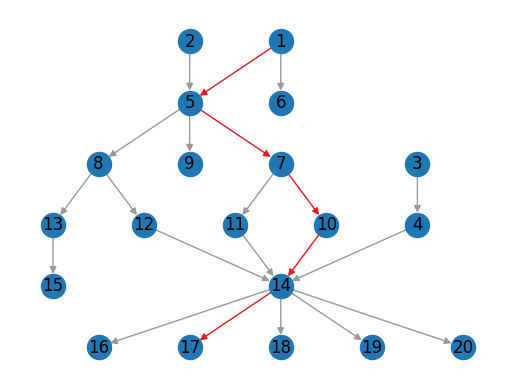

In [55]:
import networkx as nx
import matplotlib.pyplot as plt
import pydot
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_salbp_graph(SALBP_dict):
    G = nx.DiGraph()
    G.add_nodes_from(SALBP_dict["task_times"].keys())
    G.add_edges_from(SALBP_dict["precedence_relations"])
    #prints the edges
    print("from dict", SALBP_dict["precedence_relations"])
    #prints the edges from the graph
    print("from graph", G.edges())
    nx.draw(G, with_labels = True)
    plt.show()

def plot_salbp_edge_removal_graph(SALBP_dict, instance_name, res_df):
    '''Colors the edges by the number of stations in res_df'''
    G = nx.DiGraph()
    G.add_nodes_from(SALBP_dict["task_times"].keys())
    G.add_edges_from(SALBP_dict["precedence_relations"])
    edge_colors = []
    for edge in G.edges():
        edge_index = SALBP_dict["precedence_relations"].index(list(edge))
        no_stations = res_df[(res_df["instance:"] == instance_name) & (res_df["precedence_relation"] == edge_index)]["no_stations"].values[0]
        edge_colors.append(no_stations)
    #saves edge colors as graph attribute
    nx.set_edge_attributes(G, dict(zip(G.edges(), edge_colors)), "value")
    pos = nx.nx_pydot.graphviz_layout(G, prog = "dot")
   # Define colormap
    unique_values = list(set(edge_colors))
    print(unique_values)
    color_map = cm.get_cmap('viridis', len(unique_values))
    print("color map", color_map)
    cmap = mcolors.ListedColormap([color_map(val) for val in unique_values])

    # Draw graph
    #creates ax
    fig, ax = plt.subplots()
    edges = nx.draw_networkx_edges(G, pos, edge_color=edge_colors, edge_cmap=cmap, edge_vmin=min(edge_colors), edge_vmax=max(edge_colors), ax=ax)
    nx.draw_networkx_nodes(G, pos, ax=ax)
    nx.draw_networkx_labels(G, pos, ax=ax)

    # Add colorbar
    handles = [plt.Line2D([0], [0], marker='o', color = color_map(val), label=val, markersize=10) for val in unique_values]
    plt.legend(handles=handles, loc="best")

    plt.show()
    return G


def draw_graph_with_discrete_legend(SALBP_dict, res_df, instance_name,  ax=None):
    G = nx.DiGraph()
    G.add_nodes_from(SALBP_dict["task_times"].keys())
    G.add_edges_from(SALBP_dict["precedence_relations"])

    edge_colors = []
    edge_values = []  # Store unique edge values for legend

    for edge in G.edges():
        edge_index = SALBP_dict["precedence_relations"].index(list(edge))
        no_stations = res_df[(res_df["instance:"] == instance_name) & 
                             (res_df["precedence_relation"] == edge_index)]["no_stations"].values[0]
        edge_colors.append(no_stations)
        if no_stations not in edge_values:
            edge_values.append(no_stations)

    # Save edge colors as graph attribute
    nx.set_edge_attributes(G, dict(zip(G.edges(), edge_colors)), "value")

    # Graph layout
    pos = nx.nx_pydot.graphviz_layout(G, prog="dot")

    # Define discrete colormap
    unique_values = sorted(edge_values)
    num_colors = len(unique_values)
    cmap = plt.cm.get_cmap("Set1", num_colors)  # Use a qualitative colormap
    color_map = {val: cmap(i) for i, val in enumerate(unique_values)}  # Assign colors to unique values

    # Assign discrete colors to edges
    edge_color_list = [color_map[val] for val in edge_colors]

    # Draw graph
    if ax is None:
        fig, ax = plt.subplots()
    edges = nx.draw_networkx_edges(G, pos, edge_color=edge_color_list, ax=ax)
    nx.draw_networkx_nodes(G, pos, ax=ax)
    nx.draw_networkx_labels(G, pos, ax=ax)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # Create legend
    handles = [plt.Line2D([0], [0], color=color_map[val], lw=2, label=f"No. of Stations: {val}") for val in unique_values]
    #ax.legend(handles=handles, loc="best")


    return G

i = 97

test_salb = parse_alb(f"/Users/letshopethisworks2/Documents/phd_paper_material/MMABPWW/SALBP_benchmark/small data set_n=20/instance_n=20_{i}.alb")
#test_g = plot_salbp_edge_removal_graph(test_salb, f"instance_n=20_{i}", results_df)
test_g = draw_graph_with_discrete_legend(test_salb, results_df, f"instance_n=20_{i}")
#saves graph to a gephi readable file
nx.write_gexf(test_g, "test_salb.gexf")
#plot_salbp_graph(test_salb)

In [56]:
interesting_instances['instance:'].values

array(['instance_n=20_101', 'instance_n=20_102', 'instance_n=20_103',
       'instance_n=20_136', 'instance_n=20_177', 'instance_n=20_186',
       'instance_n=20_241', 'instance_n=20_244', 'instance_n=20_247',
       'instance_n=20_25', 'instance_n=20_251', 'instance_n=20_253',
       'instance_n=20_254', 'instance_n=20_255', 'instance_n=20_264',
       'instance_n=20_265', 'instance_n=20_269', 'instance_n=20_270',
       'instance_n=20_271', 'instance_n=20_274', 'instance_n=20_278',
       'instance_n=20_321', 'instance_n=20_326', 'instance_n=20_327',
       'instance_n=20_34', 'instance_n=20_340', 'instance_n=20_38',
       'instance_n=20_394', 'instance_n=20_401', 'instance_n=20_402',
       'instance_n=20_404', 'instance_n=20_409', 'instance_n=20_411',
       'instance_n=20_412', 'instance_n=20_414', 'instance_n=20_466',
       'instance_n=20_467', 'instance_n=20_468', 'instance_n=20_469',
       'instance_n=20_470', 'instance_n=20_473', 'instance_n=20_474',
       'instance_n=20_4

/var/folders/6v/7nrd1rj91hx3tb4q5npbdf0w0000gn/T/ipykernel_46424/2280055115.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("Set1", num_colors)  # Use a qualitative colormap
/var/folders/6v/7nrd1rj91hx3tb4q5npbdf0w0000gn/T/ipykernel_46424/2280055115.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("Set1", num_colors)  # Use a qualitative colormap
/var/folders/6v/7nrd1rj91hx3tb4q5npbdf0w0000gn/T/ipykernel_46424/2280055115.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``mat

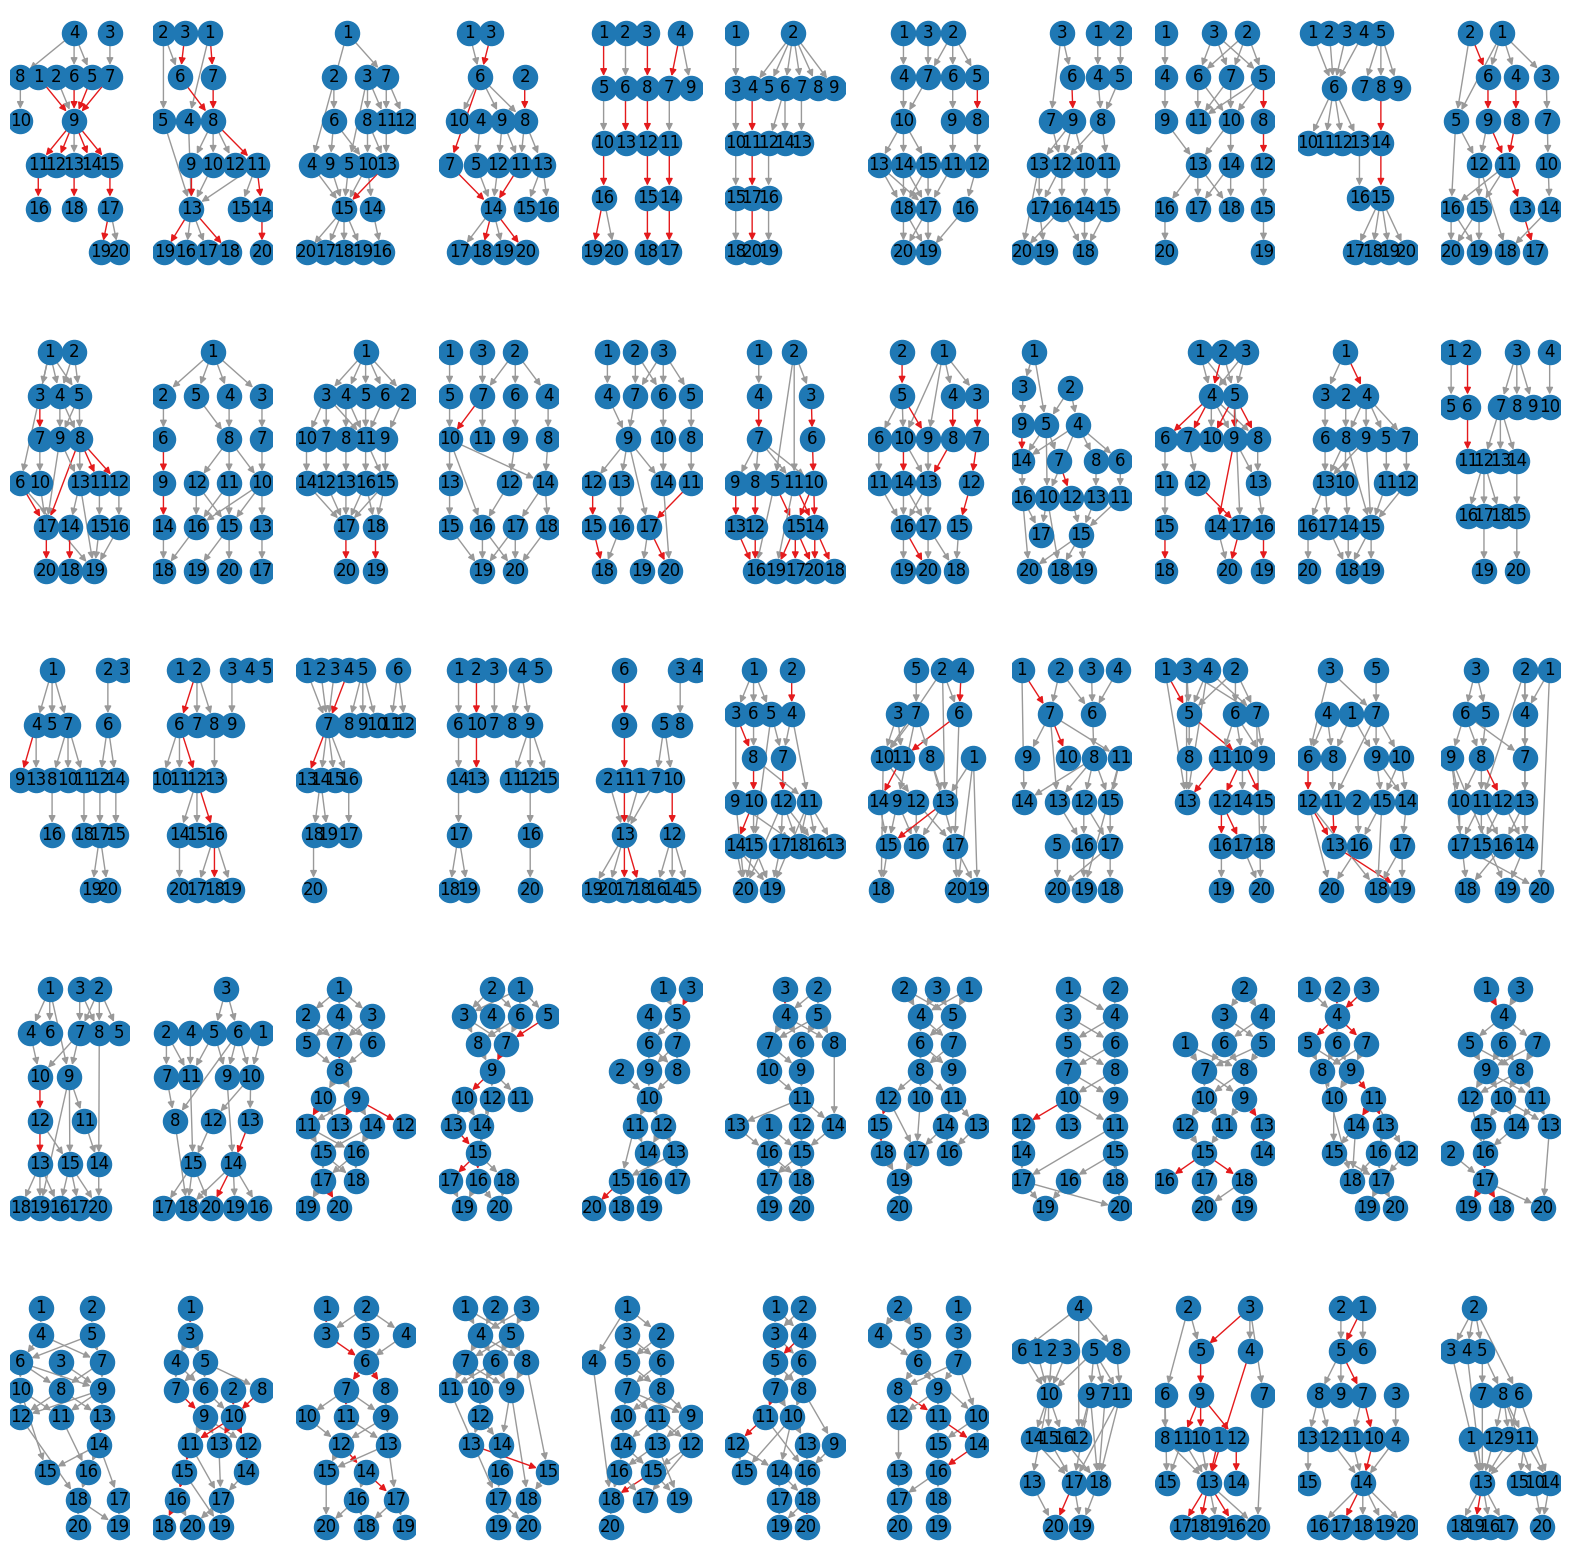

In [57]:
#creates a plot of the 27 graphs of interest
fig, axs = plt.subplots(5, 11, figsize=(20, 20))
axs = axs.ravel()
for idx, i in enumerate(interesting_instances['instance:'].values):
    test_salb = parse_alb(f"/Users/letshopethisworks2/Documents/phd_paper_material/MALBP_instance_generation/SALBP_benchmark/small data set_n=20/{i}.alb")
    #test_g = plot_salbp_edge_removal_graph(test_salb, f"instance_n=20_{i}", results_df)
    test_g = draw_graph_with_discrete_legend(test_salb, results_df, i, ax=axs[idx])
    #adds test_g to the axs

plt.show()

In [ ]:
# results_50 = pd.read_csv("SALBP_edge_solutions.csv")
# #changes 20 in instance: to 50
# results_50['instance:'] = results_50['instance:'].str.replace("20", "50")
# #creates a seperate dataframe for the instances with None precedence relations
# lb_df_50 = results_50[results_50["precedence_relation"].isna() == True].copy()
# #removes the rows with None precedence relations
# results_50 = results_50[results_50['precedence_relation'].isna() == False]
# #gets the min and max number of stations for each instance
# min_and_max_50 = results_50.groupby("instance:")["no_stations"].agg(["min", "max"])
# min_and_max_50.reset_index(inplace = True)
# #adds in lb values
# lb_df_50['bin_lb'] = lb_df_50['no_stations']
# min_and_max_50 = pd.merge(min_and_max_50, lb_df_50[["instance:", "bin_lb"]], on = "instance:")
# #counts the number of times min does not equal max
# min_and_max_50["min_not_equal_max"] = min_and_max_50["min"] != min_and_max_50["max"]
# min_and_max_50["min_not_equal_max"].sum()

37

In [ ]:
#looks at instances where the min is not equal to the max
# interesting_instances_50 = min_and_max_50[min_and_max_50["min_not_equal_max"]]
# interesting_instances_50

,instance:,min,max,bin_lb,min_not_equal_max
6,instance_n=50_101,29,30,29,True
7,instance_n=50_102,31,32,30,True
11,instance_n=50_106,27,28,27,True
13,instance_n=50_108,29,30,29,True
14,instance_n=50_109,29,30,29,True
19,instance_n=50_112,26,27,26,True
20,instance_n=50_113,27,28,27,True
22,instance_n=50_115,27,28,26,True
23,instance_n=50_116,31,32,31,True
24,instance_n=50_117,26,27,26,True


In [ ]:
results_df
#merges min and max 

,Unnamed: 0,instance:,precedence_relation,no_stations,optimal,cpu
0,0,instance_n=20_1,0.0,3,1,0.0
1,1,instance_n=20_1,1.0,3,1,0.0
2,2,instance_n=20_1,2.0,3,1,0.0
3,3,instance_n=20_1,3.0,3,1,0.0
4,4,instance_n=20_1,4.0,3,1,0.0
...,...,...,...,...,...,...
3697,3697,instance_n=20_524,12.0,3,1,0.0
3698,3698,instance_n=20_524,13.0,3,1,0.0
3699,3699,instance_n=20_524,14.0,3,1,0.0
3700,3700,instance_n=20_524,15.0,3,1,0.0


In [68]:
#merges results with min and max
results_df = pd.merge(results_df, min_and_max, on = "instance:")
results_df

,Unnamed: 0,instance:,precedence_relation,no_stations,optimal,cpu,min,max,bin_lb,min_not_equal_max,bin_lb_less_than_min,bin_lb_less_than_max
0,0,instance_n=20_1,0.0,3,1,0.0,3,3,3,False,False,False
1,1,instance_n=20_1,1.0,3,1,0.0,3,3,3,False,False,False
2,2,instance_n=20_1,2.0,3,1,0.0,3,3,3,False,False,False
3,3,instance_n=20_1,3.0,3,1,0.0,3,3,3,False,False,False
4,4,instance_n=20_1,4.0,3,1,0.0,3,3,3,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
11808,3697,instance_n=20_524,12.0,3,1,0.0,3,3,3,False,False,False
11809,3698,instance_n=20_524,13.0,3,1,0.0,3,3,3,False,False,False
11810,3699,instance_n=20_524,14.0,3,1,0.0,3,3,3,False,False,False
11811,3700,instance_n=20_524,15.0,3,1,0.0,3,3,3,False,False,False
